# mr-ash simulation ash paper scenarios

I look at various types of underlying mixture distribution of effect size, including those explored in Figure 2 of [ash paper](https://academic.oup.com/biostatistics/article/18/2/275/2557030/False-discovery-rates-a-new-deal), with different proportions of $\pi_0 \in \{0.5, 0.9, 0.995, 0.999\}$, and different genotype structure

## Effect size

![](img/mixtures.png)

## Two types of genotypes
In addition to using the original genotype data we also created a genotype data without any LD -- we permute for each variant the sample genotypes to break any potential inter-variant correlations. Here is what we get for the LD structure, compared with [the original](MR_ASH_Simulation.html#View-and-select-LD-structure):

![](img/ENSG00000264247.permuted.ld.png)

## Simulation runs
One replicate multiple scenarios

```
sos run 20170624_Simulation_Procedures.ipynb --pi0 0.5 0.9 0.995 0.999 \
    --shape spiky near_normal flat_top skew big_normal 'bimodal' \
    --n_rep 1
    
sos run 20170624_Simulation_Procedures.ipynb --pi0 0.5 0.9 0.995 0.999 \
    --shape spiky near_normal flat_top skew big_normal 'bimodal' \
    --n_rep 1 --permute_genotype True
```
One scenario multiple replicates


```
sos run 20170624_Simulation_Procedures.ipynb --pi0 0.999 \
    --shape near_normal \
    --n_rep 20
    
sos run 20170624_Simulation_Procedures.ipynb --pi0 0.999 \
    --shape near_normal \
    --n_rep 20 --permute_genotype True
```

## Data analysis

For simulated data we perform 3 analysis:
1. Univariate analysis (R's `lm()`)
2. `mr-ash` analysis 
3. `ash` analysis using results from 1

Results are stored at: `/project/compbio/GTEx_eQTL/MRASH_results/Simulation`. 

## Highlights
### For genotype without LD convolution
These are results with `permuted` in the file name.
1. When signal is dense and slap `mr-ash` will generate a quite sparse solution with much over estimated $\hat{\sigma}$. In the case of 50% signal `mr-ash` estimates $\hat{\sigma} > 4000$ whereas the truth is 1. (see file `0p5_big_normal_1.expr.analyzed.pdf`). There is a big difference between `mr-ash` and `ash` results, too. Effect size estimate of `mr-ash` is very problematic.
2. There is less over estimate of $\hat{\sigma}$ when signal is more spiky. (see file `0p5_near_normal_1.expr.analyzed.pdf` and `0p5_spiky_1.expr.analyzed.pdf`)
3. In a somewhat more realistic scenario both `ash` and `mr-ash` can do quite good job. There does not seem to have a particular harm using `mr-ash`. (see file `0p999_big_normal_1.expr.analyzed.pdf`)
4. The difference between `mr-ash` and `ash` in the more realistic scenario above is even less obvious when signal is more spiky. (see file `0p999_near_normal_1.expr.analyzed.pdf` and `0p999_spiky_1.expr.analyzed.pdf`). In fact both `mr-ash` and `ash` recovers the true signal less well than the more slap situation (but maybe slap situation is more realistic?).

### For genotype with LD convolution
These are results without `permuted` in the file name.
1. When signal is dense and slap, `mr-ash` suffers the same problem as before though the estimate of effect size is much better. But in this scenario `ash` result over estimates effect size even more than plain univariate analysis. (see file `0p5_big_normal_1.expr.analyzed.pdf`)
2. In a somewhat more realistic scenario (see file `0p999_big_normal_1.expr.analyzed.pdf`) the advantage of `mr-ash` is obvious. However there is still a slight over-estimate of $\hat{\sigma}$.
3. When signal gets more spiky, there seems a slight under-estimate of $\hat{\sigma}$. Still `mr-ash` does better than `ash`. (see file `0p999_near_normal_1.expr.analyzed.pdf` and `0p999_spiky_1.expr.analyzed.pdf`)

### Average  results over replicates
Here we [compare CDF of estimates with the truth](http://stephenslab.github.io/ash/analysis/plot_cdf_eg.html) for multiple replicates. Here I only looked what we think the most "realistic" situation: $\pi_0 = 99.9%$ and near-normal mixture. The good result below is consistent with the observation that the signals `mr-ash` identifies agree with the truth, in this setup.

In [2]:
parameter: fns = glob.glob('/home/gaow/Documents/GTEx/Simulation/TY.genotype.permuted.0p999_near_normal_*.expr.analyzed.rds')
output: '/home/gaow/Documents/GTEx/Simulation/cdf_compare.rds'
R:
  x = seq(-6,6,length = 500)
  cdf_dat_all = list()
  idx = 0
  for (d in c(${fns!r,})) {
      idx = idx + 1
      dat = readRDS(d)
      cdf_dat = NULL
      for (table in names(dat)) {
          res = dat[[table]]
          g0 = ashr::normalmix(c(res$meta$pi0, (1 - res$meta$pi0) * res$meta$pi), rep(0, length(res$meta$sigma)+1), c(0, res$meta$sigma))
          g1 = ashr::normalmix(res$mr.ash$w, rep(0, length(res$mr.ash$sa)), sqrt(res$mr.ash$sa))
          d0 = data.frame(x = x,y = as.numeric(ashr::mixcdf(g0,x)), method="truth", scenario = table)
          d1 = data.frame(x = x,y = as.numeric(ashr::mixcdf(g1,x)), method="mr-ash", scenario = table)
          if (is.null(cdf_dat)) cdf_dat = rbind(d0, d1)
          else cdf_dat = rbind(cdf_dat, d0, d1)
      }
      cdf_dat_all[[idx]] = cdf_dat
  }
  saveRDS(cdf_dat_all, file = ${output!r})

For even just one replicate:

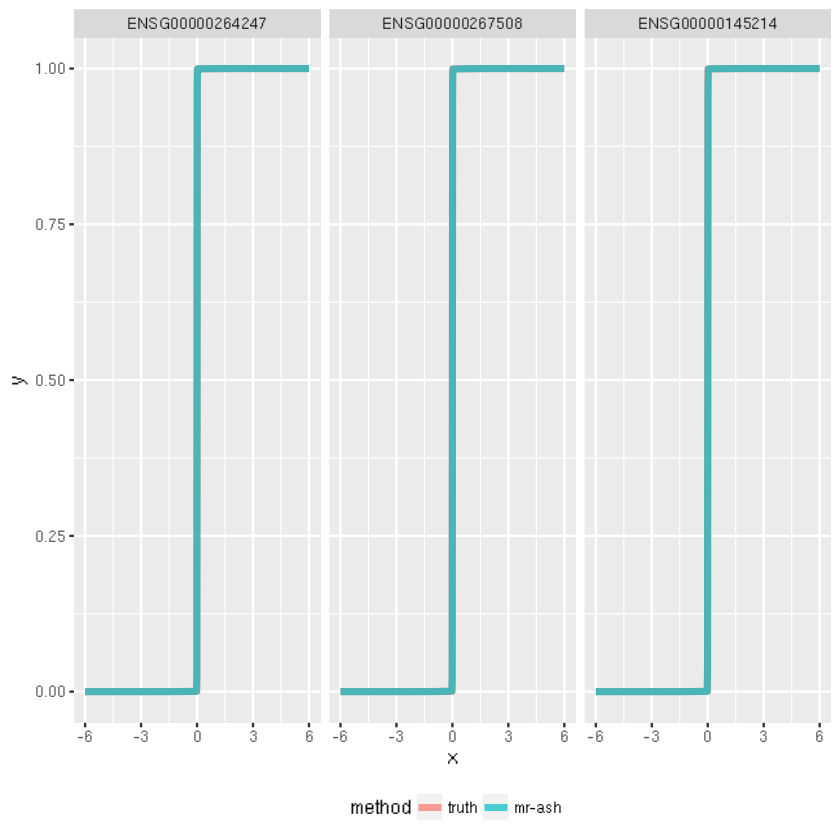

In [4]:
dat = readRDS('/home/gaow/Documents/GTEx/Simulation/cdf_compare.rds')
library(ggplot2)
ggplot(dat[[1]], aes(x = x,y = y,color = method)) + 
    geom_line(lwd = 1.5,alpha = 0.7) + facet_grid(.~scenario) + 
    theme(legend.position = "bottom")